In [1]:
#  imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [2]:
df = pd.read_csv("Advertising.csv")
df = df.drop(columns=["Unnamed: 0"])

In [3]:
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [5]:
df.isnull().sum()

,0
TV,0
Radio,0
Newspaper,0
Sales,0


In [6]:
df.duplicated().sum()

0

In [7]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df[(df["Newspaper"] > (Q3["Newspaper"] + 1.5 * IQR["Newspaper"]))]

,TV,Radio,Newspaper,Sales
16,67.8,36.6,114.0,12.5
101,296.4,36.3,100.9,23.8


After removing outliers:


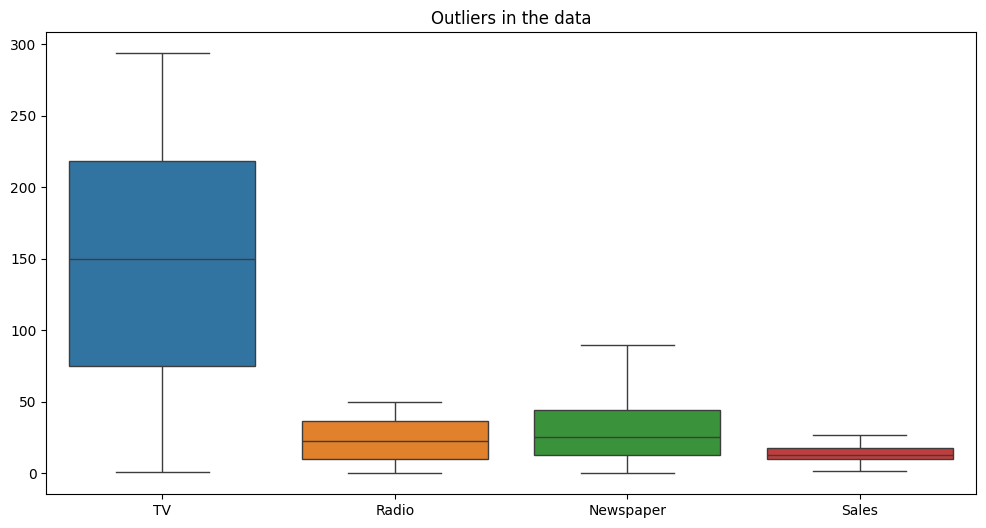

In [8]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

print('After removing outliers:')

# check for outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.title("Outliers in the data")
plt.show()

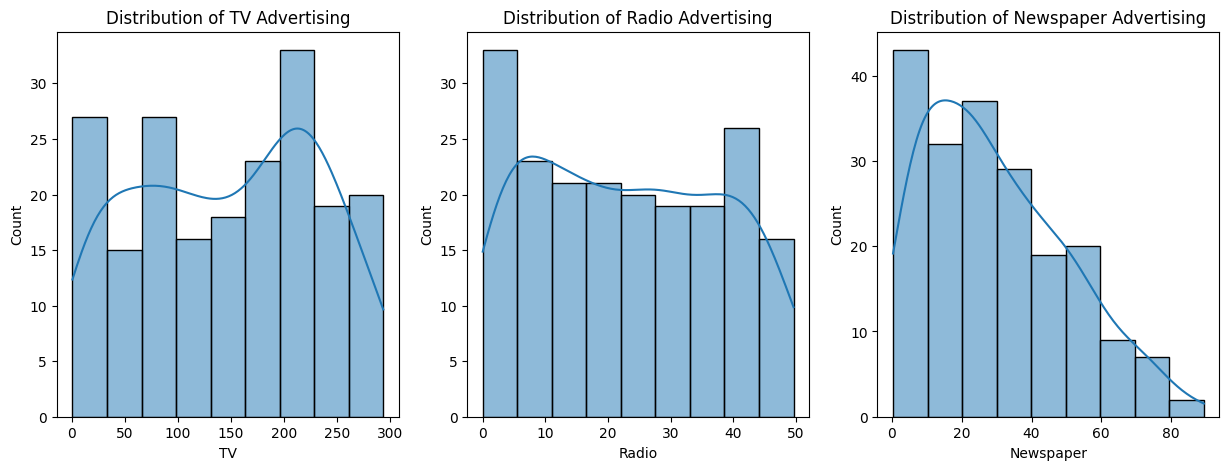

In [9]:
# Plot histograms for independent variables
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df['TV'], kde=True)
plt.title('Distribution of TV Advertising')

plt.subplot(1, 3, 2)
sns.histplot(df['Radio'], kde=True)
plt.title('Distribution of Radio Advertising')

plt.subplot(1, 3, 3)
sns.histplot(df['Newspaper'], kde=True)
plt.title('Distribution of Newspaper Advertising')

plt.show()

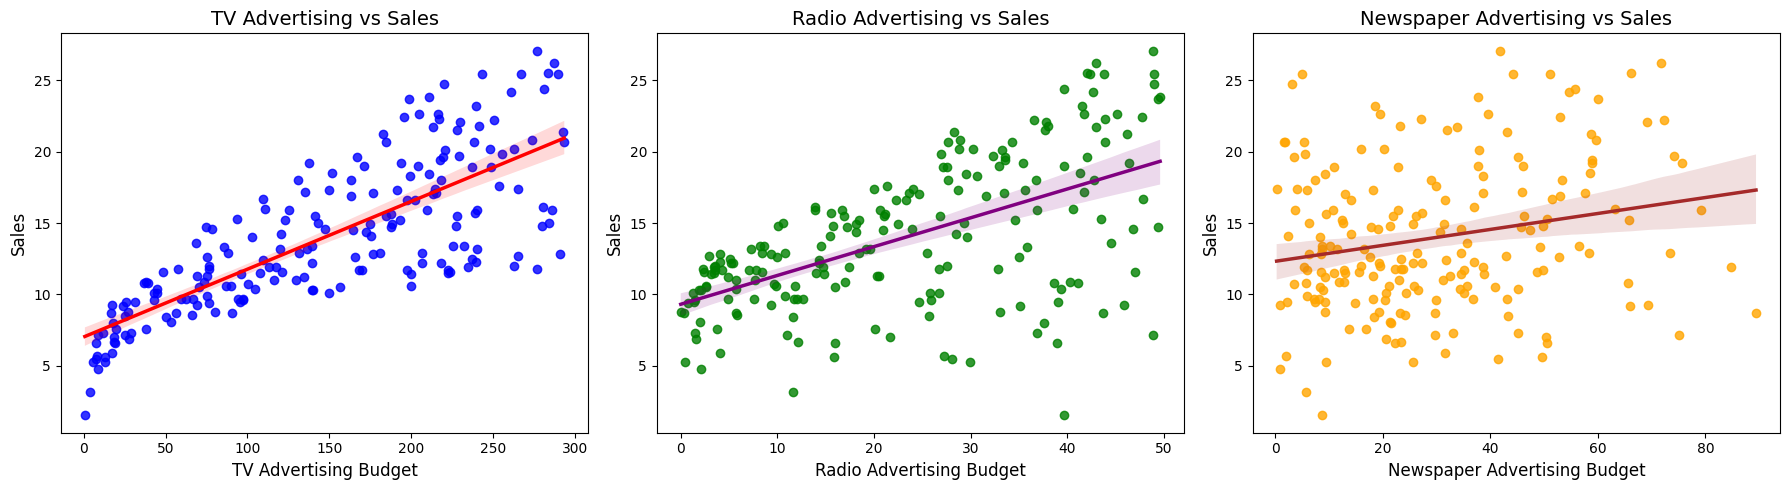

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# LM plot for TV vs Sales
sns.regplot(x='TV', y='Sales', data=df,
            scatter_kws={'color': 'blue', 'alpha': 0.8},
            line_kws={'color': 'red', 'linewidth': 2.5},
            ax=axes[0])
axes[0].set_title('TV Advertising vs Sales', fontsize=14)
axes[0].set_xlabel('TV Advertising Budget', fontsize=12)
axes[0].set_ylabel('Sales', fontsize=12)

# LM plot for Radio vs Sales
sns.regplot(x='Radio', y='Sales', data=df,
            scatter_kws={'color': 'green', 'alpha': 0.8},
            line_kws={'color': 'purple', 'linewidth': 2.5},
            ax=axes[1])
axes[1].set_title('Radio Advertising vs Sales', fontsize=14)
axes[1].set_xlabel('Radio Advertising Budget', fontsize=12)
axes[1].set_ylabel('Sales', fontsize=12)

# LM plot for Newspaper vs Sales
sns.regplot(x='Newspaper', y='Sales', data=df,
            scatter_kws={'color': 'orange', 'alpha': 0.8},
            line_kws={'color': 'brown', 'linewidth': 2.5},
            ax=axes[2])
axes[2].set_title('Newspaper Advertising vs Sales', fontsize=14)
axes[2].set_xlabel('Newspaper Advertising Budget', fontsize=12)
axes[2].set_ylabel('Sales', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


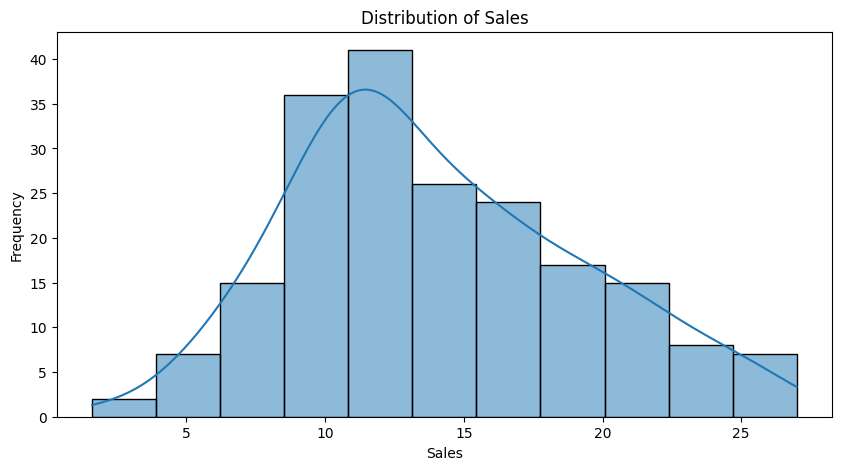

In [11]:

# Plot histogram for the target variable
plt.figure(figsize=(10, 5))
sns.histplot(df['Sales'], kde=True)
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()


In [12]:
# Feature Engineering: Create new features
df["Total_Advertising"] = df["TV"] + df["Radio"] + df["Newspaper"]
df["TV_Radio_Interaction"] = df["TV"] * df["Radio"]

In [13]:
correlation_matrix = df.corr()
correlation_matrix


,TV,Radio,Newspaper,Sales,Total_Advertising,TV_Radio_Interaction
TV,1.000000,0.051978,0.049771,0.779121,0.948643,0.656111
Radio,0.051978,1.000000,0.346364,0.576748,0.286933,0.684107
Newspaper,0.049771,0.346364,1.000000,0.219555,0.324576,0.240622
Sales,0.779121,0.576748,0.219555,1.000000,0.865973,0.963375
Total_Advertising,0.948643,0.286933,0.324576,0.865973,1.000000,0.773712
TV_Radio_Interaction,0.656111,0.684107,0.240622,0.963375,0.773712,1.000000


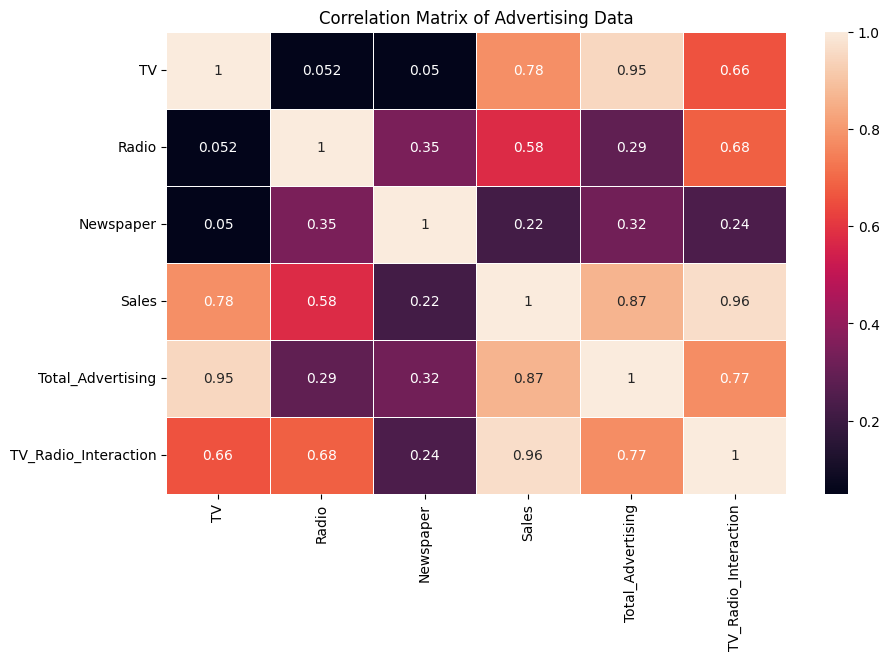

In [14]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, linewidths=0.5)
plt.title('Correlation Matrix of Advertising Data')
plt.show()


In [15]:
X = df.drop("Sales", axis=1)
y = df["Sales"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps
preprocessor = Pipeline(steps=[
    ("scaler", StandardScaler())  # Normalize features
])

# Define models and their hyperparameter grids
models = {
    "linear_regression": (LinearRegression(), {}),
    "ridge_regression": (Ridge(), {"ridge_regression__alpha": [0.1, 1.0, 10.0]}),
    "lasso_regression": (Lasso(), {"lasso_regression__alpha": [0.1, 1.0, 10.0]}),
    "decision_tree": (DecisionTreeRegressor(random_state=42), {"decision_tree__max_depth": [5, 10, 20]}),
    "random_forest": (RandomForestRegressor(random_state=42), {"random_forest__n_estimators": [50, 100], "random_forest__max_depth": [10, 20]}),
    "k_nearest_neighbors": (KNeighborsRegressor(), {"k_nearest_neighbors__n_neighbors": [3, 5, 7]}),
}

# Create a pipeline for each model and perform hyperparameter tuning
results = {}

for model_name, (model, param_grid) in models.items():
    print(f"Training {model_name}...")
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        (model_name, model)
    ])

    # Use GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="r2")
    grid_search.fit(X_train, y_train)

    # Evaluate the model
    y_pred = grid_search.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Store results
    results[model_name] = {
        "Best Parameters": grid_search.best_params_,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    }

# Sort the results by RMSE in ascending order
sorted_results = sorted(results.items(), key=lambda x: x[1]["RMSE"])

# Print sorted results
print("\nModel Evaluation Results (Sorted by RMSE in Ascending Order):")
for model_name, result in sorted_results:
    print(f"{model_name}:")
    print(f"  Best Parameters: {result['Best Parameters']}")
    print(f"  MAE: {result['MAE']}")
    print(f"  MSE: {result['MSE']}")
    print(f"  RMSE: {result['RMSE']}")
    print(f"  R²: {result['R²']}")
    print()

# Display the best model with all metrics
best_model_name = sorted_results[0][0]
best_model_result = sorted_results[0][1]
print("\nBest Model:")
print(f"{best_model_name}:")
print(f"  Best Parameters: {best_model_result['Best Parameters']}")
print(f"  MAE: {best_model_result['MAE']}")
print(f"  MSE: {best_model_result['MSE']}")
print(f"  RMSE: {best_model_result['RMSE']}")
print(f"  R²: {best_model_result['R²']}")

Training linear_regression...
Training ridge_regression...
Training lasso_regression...
Training decision_tree...
Training random_forest...
Training k_nearest_neighbors...

Model Evaluation Results (Sorted by RMSE in Ascending Order):
random_forest:
  Best Parameters: {'random_forest__max_depth': 10, 'random_forest__n_estimators': 100}
  MAE: 0.45796851190476584
  MSE: 0.32004890405686703
  RMSE: 0.5657286487856763
  R²: 0.988200135528134

decision_tree:
  Best Parameters: {'decision_tree__max_depth': 10}
  MAE: 0.6837499999999999
  MSE: 0.6780625
  RMSE: 0.8234455051793045
  R²: 0.9750005530341296

linear_regression:
  Best Parameters: {}
  MAE: 0.7257189395229021
  MSE: 0.7592614823099678
  RMSE: 0.8713561168144559
  R²: 0.9720068324671601

ridge_regression:
  Best Parameters: {'ridge_regression__alpha': 0.1}
  MAE: 0.7264621113428933
  MSE: 0.7611291044815169
  RMSE: 0.872427134196041
  R²: 0.9719379752136917

lasso_regression:
  Best Parameters: {'lasso_regression__alpha': 0.1}
  M

In [16]:
y_train_pred = grid_search.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)

# Evaluate the best model on the test set
y_test_pred = grid_search.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print("Training Set Evaluation:")
print(f"  MAE: {train_mae}")
print(f"  MSE: {train_mse}")
print(f"  RMSE: {train_rmse}")
print(f"  R²: {train_r2}")

print("\nTest Set Evaluation:")
print(f"  MAE: {test_mae}")
print(f"  MSE: {test_mse}")
print(f"  RMSE: {test_rmse}")
print(f"  R²: {test_r2}")

Training Set Evaluation:
  MAE: 0.5094936708860761
  MSE: 0.4926090014064698
  RMSE: 0.7018610983709453
  R²: 0.9816083900930789

Test Set Evaluation:
  MAE: 0.8266666666666665
  MSE: 1.327555555555556
  RMSE: 1.1521959709856462
  R²: 0.9510544312576529


In [17]:
best_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    (best_model_name, models[best_model_name][0])
])
best_pipeline.fit(X_train, y_train)

# Define the file path for saving the model
model_path = f"{best_model_name}.pkl"
joblib.dump(best_pipeline, model_path)
print(f"\nBest Model Saved: {model_path}")

# Load the saved model and make predictions
loaded_model = joblib.load(model_path)
y_pred_loaded = loaded_model.predict(X_test)

# Evaluate the loaded model
mae_loaded = mean_absolute_error(y_test, y_pred_loaded)
mse_loaded = mean_squared_error(y_test, y_pred_loaded)
rmse_loaded = np.sqrt(mse_loaded)
r2_loaded = r2_score(y_test, y_pred_loaded)

# Display evaluation metrics
print("\nEvaluation Metrics for Loaded Model:")
print(f"  MAE: {mae_loaded}")
print(f"  MSE: {mse_loaded}")
print(f"  RMSE: {rmse_loaded}")
print(f"  R²: {r2_loaded}")


Best Model Saved: random_forest.pkl

Evaluation Metrics for Loaded Model:
  MAE: 0.46122500000000305
  MSE: 0.32413427500000347
  RMSE: 0.5693279151771881
  R²: 0.9880495122238976
